In [1]:
import numpy as np
import os
import pickle
import json
import matplotlib.pyplot as plt
from surface_level_analyses import LexicalSurfaceLevelAnalysis

## Step One: Compute a random subset of contexts summing up to 2000 utterances

In [2]:
import random
ANALYSIS_PATH = '/home/mog29/cogen/data_and_checkpoints/continual_learning/analysis/human_human.json'
with open(ANALYSIS_PATH, 'r') as f:
    human_human = json.load(f)

CACHE_PATH = '/home/mog29/cogen/paper_analysis/analysis_cache/game_subsets'
for i in range(1, 5):
    # Get round games
    game_round_pairs = []
    for game_id, game_dict in human_human.items():
        if f'r{i}' not in game_id:
            continue
        for round_idx, round_dict in game_dict.items():
            game_round_pairs.append((game_id, round_idx))
    random.shuffle(game_round_pairs)
    print(len(game_round_pairs))

    with open(os.path.join(CACHE_PATH, f'round_{i}_subsets_alt.pkl'), 'wb') as f:
        pickle.dump(game_round_pairs[:1949], f)

1949
2431
2992
3439


## Step Two: Process Things

In [2]:
train_set_analysis = LexicalSurfaceLevelAnalysis("training")
TREATMENTS = ['full', 'no_ji', 'no_ds', 'baseline']
for treatment in TREATMENTS:
    for i in range(1, 6):
        print(treatment, i)
        train_set_analysis.add_utterances(treatment, i)

generation_analysis = LexicalSurfaceLevelAnalysis("generation")
TREATMENTS = ['full', 'no_ji', 'no_ds', 'baseline']
for treatment in TREATMENTS:
    start_i = 1 if treatment in ['full', 'no_ji'] else 2
    for i in range(start_i, 5):
        print(treatment, i)
        generation_analysis.add_utterances(treatment, i)

full 1
full 2
full 3
full 4
full 5
no_ji 1
no_ji 2
no_ji 3
no_ji 4
no_ji 5
no_ds 1
no_ds 2
no_ds 3
no_ds 4
no_ds 5
baseline 1
baseline 2
baseline 3
baseline 4
baseline 5
full 1
full 2
full 3
full 4
no_ji 1
no_ji 2
no_ji 3
no_ji 4
no_ds 2
no_ds 3
no_ds 4
baseline 2
baseline 3
baseline 4


In [3]:
single_sample_analysis = LexicalSurfaceLevelAnalysis("generation")
TREATMENTS = ['no_ji', 'baseline']
for treatment in TREATMENTS:
    start_i = 1 if treatment in ['full', 'no_ji'] else 2
    suffix = 'single_sample'
    for i in range(start_i, 5):
        print(treatment, i)
        single_sample_analysis.add_utterances(treatment, i, suffix=suffix)

no_ji 1
no_ji 2
no_ji 3
no_ji 4
baseline 2
baseline 3
baseline 4


In [4]:
human_human_analysis = LexicalSurfaceLevelAnalysis("human")
for i in range(1, 5):
    print('human', i)
    human_human_analysis.add_utterances('human', i)

human 1
human 2
human 3
human 4


## Utterance Length and Vocabulary Size

full [9.73, 8.51, 8.5, 7.55]
no_ji [10.37, 8.31, 7.36, 7.65]
no_ds [9.73, 9.67, 9.04, 9.47]
baseline [10.37, 9.56, 9.56, 9.35]
human [11.02, 9.8, 8.94, 7.98]


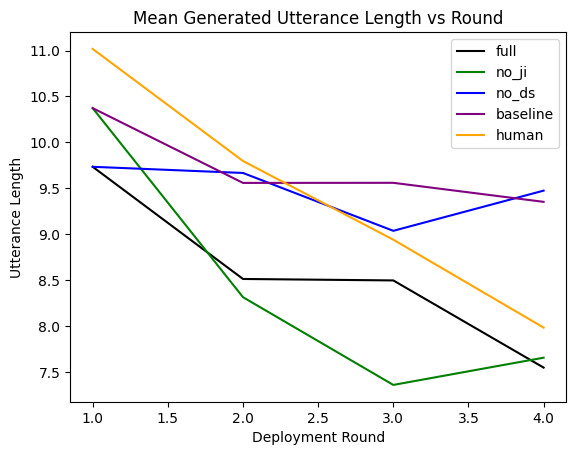

In [5]:
# Utterance length

plt.title('Mean Generated Utterance Length vs Round')
plt.xlabel('Deployment Round')
plt.ylabel('Utterance Length')

treatment_to_color = {
    'full' : 'black', 'no_ji' : 'green', 'no_ds' : 'blue', 'baseline' : 'purple', 'human' : 'orange'
}

TREATMENTS = ['full', 'no_ji', 'no_ds', 'baseline']
for treatment in TREATMENTS + ["human"]:
    x = list(range(1, 5))
    color = treatment_to_color[treatment]

    lengths = []
    for i in x:
        use_subset = True
        if treatment == "human":
            _, utt_length = human_human_analysis.utterance_length(treatment, i, use_subset=use_subset)
        else:
            curr_treatment = treatment
            if i == 1 and treatment in ['no_ds', 'baseline']:
                curr_treatment = 'full' if treatment == 'no_ds' else 'no_ji'
            _, utt_length = generation_analysis.utterance_length(curr_treatment, i, use_subset=use_subset)
        lengths.append(utt_length)

    plt.plot(x, lengths, label=treatment, color=color)
    print(treatment, [round(length, 2) for length in lengths])

plt.legend()
plt.show()

full [670, 714, 658, 634]
no_ji [643, 594, 559, 596]
no_ds [670, 634, 602, 600]
baseline [643, 538, 508, 507]
human [1429, 1321, 1172, 1205]


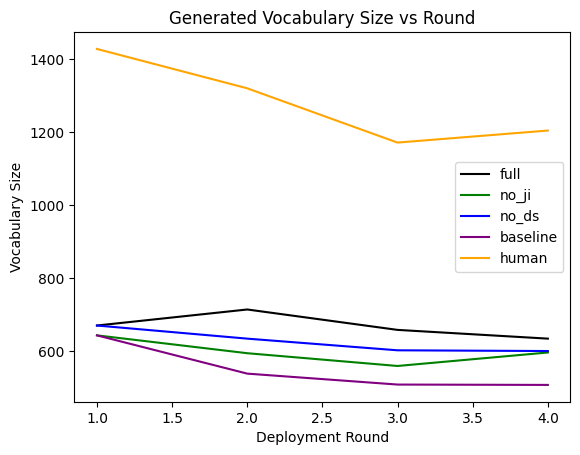

In [6]:
plt.title('Generated Vocabulary Size vs Round')
plt.xlabel('Deployment Round')
plt.ylabel('Vocabulary Size')

for treatment in TREATMENTS + ['human']:
    x = list(range(1, 5))
    color = treatment_to_color[treatment]

    vocab_sizes = []
    for i in x:
        use_subset = True
        if treatment == "human":
            _, vocab_size = human_human_analysis.vocabulary_size(treatment, i, use_subset=use_subset)
        else:
            curr_treatment = treatment
            if i == 1 and treatment in ['no_ds', 'baseline']:
                curr_treatment = 'full' if treatment == 'no_ds' else 'no_ji'
            _, vocab_size = generation_analysis.vocabulary_size(curr_treatment, i, use_subset=use_subset)
        vocab_sizes.append(vocab_size)

    plt.plot(x, vocab_sizes, label=treatment, color=color)
    print(treatment, vocab_sizes)

plt.legend()
plt.show()

In [7]:
def new_words_in_generation(treatment, round_idx):
    seen_words = set()
    for i in range(1, round_idx):
        use_subset = True
        curr_treatment = treatment
        if i == 1 and treatment in ['no_ds', 'baseline']:
            curr_treatment = 'full' if treatment == 'no_ds' else 'no_ji'
        generated_vocab, _ = generation_analysis.vocabulary_size(curr_treatment, i, use_subset=use_subset)
        for word in generated_vocab:
            seen_words.add(word)

    generated_vocab, _ = generation_analysis.vocabulary_size(treatment, round_idx, use_subset=True)
    new_words = [word for word in generated_vocab if word not in seen_words]
    return len(new_words)

full [251, 114, 94]
no_ji [172, 94, 68]
no_ds [173, 91, 72]
baseline [105, 47, 24]


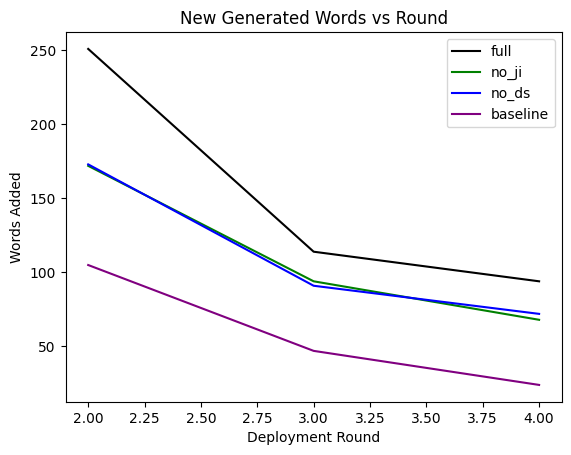

In [8]:
plt.title('New Generated Words vs Round')
plt.xlabel('Deployment Round')
plt.ylabel('Words Added')

for treatment in TREATMENTS:
    x = list(range(2, 5))
    color = treatment_to_color[treatment]

    num_added = []
    for i in x:
        num_added.append(new_words_in_generation(treatment, i))
    plt.plot(x, num_added, label=treatment, color=color)
    print(treatment, num_added)

plt.legend()
plt.show()

## Dependency Parse Metrics

full [1.7257593455515465, 1.7799070505554295, 1.7553790987178326, 1.7657243775389337]
no_ji [1.711366277528412, 1.6106745664975093, 1.4860098995941469, 1.5334692531352552]
no_ds [1.7257593455515465, 1.7469309991753883, 1.7594064854221882, 1.7976114052946057]
baseline [1.711366277528412, 1.634739901273567, 1.6111098785450728, 1.6248434159142822]
human [1.7048368754411538, 1.6538659837525205, 1.57763107731548, 1.5635591473376105]


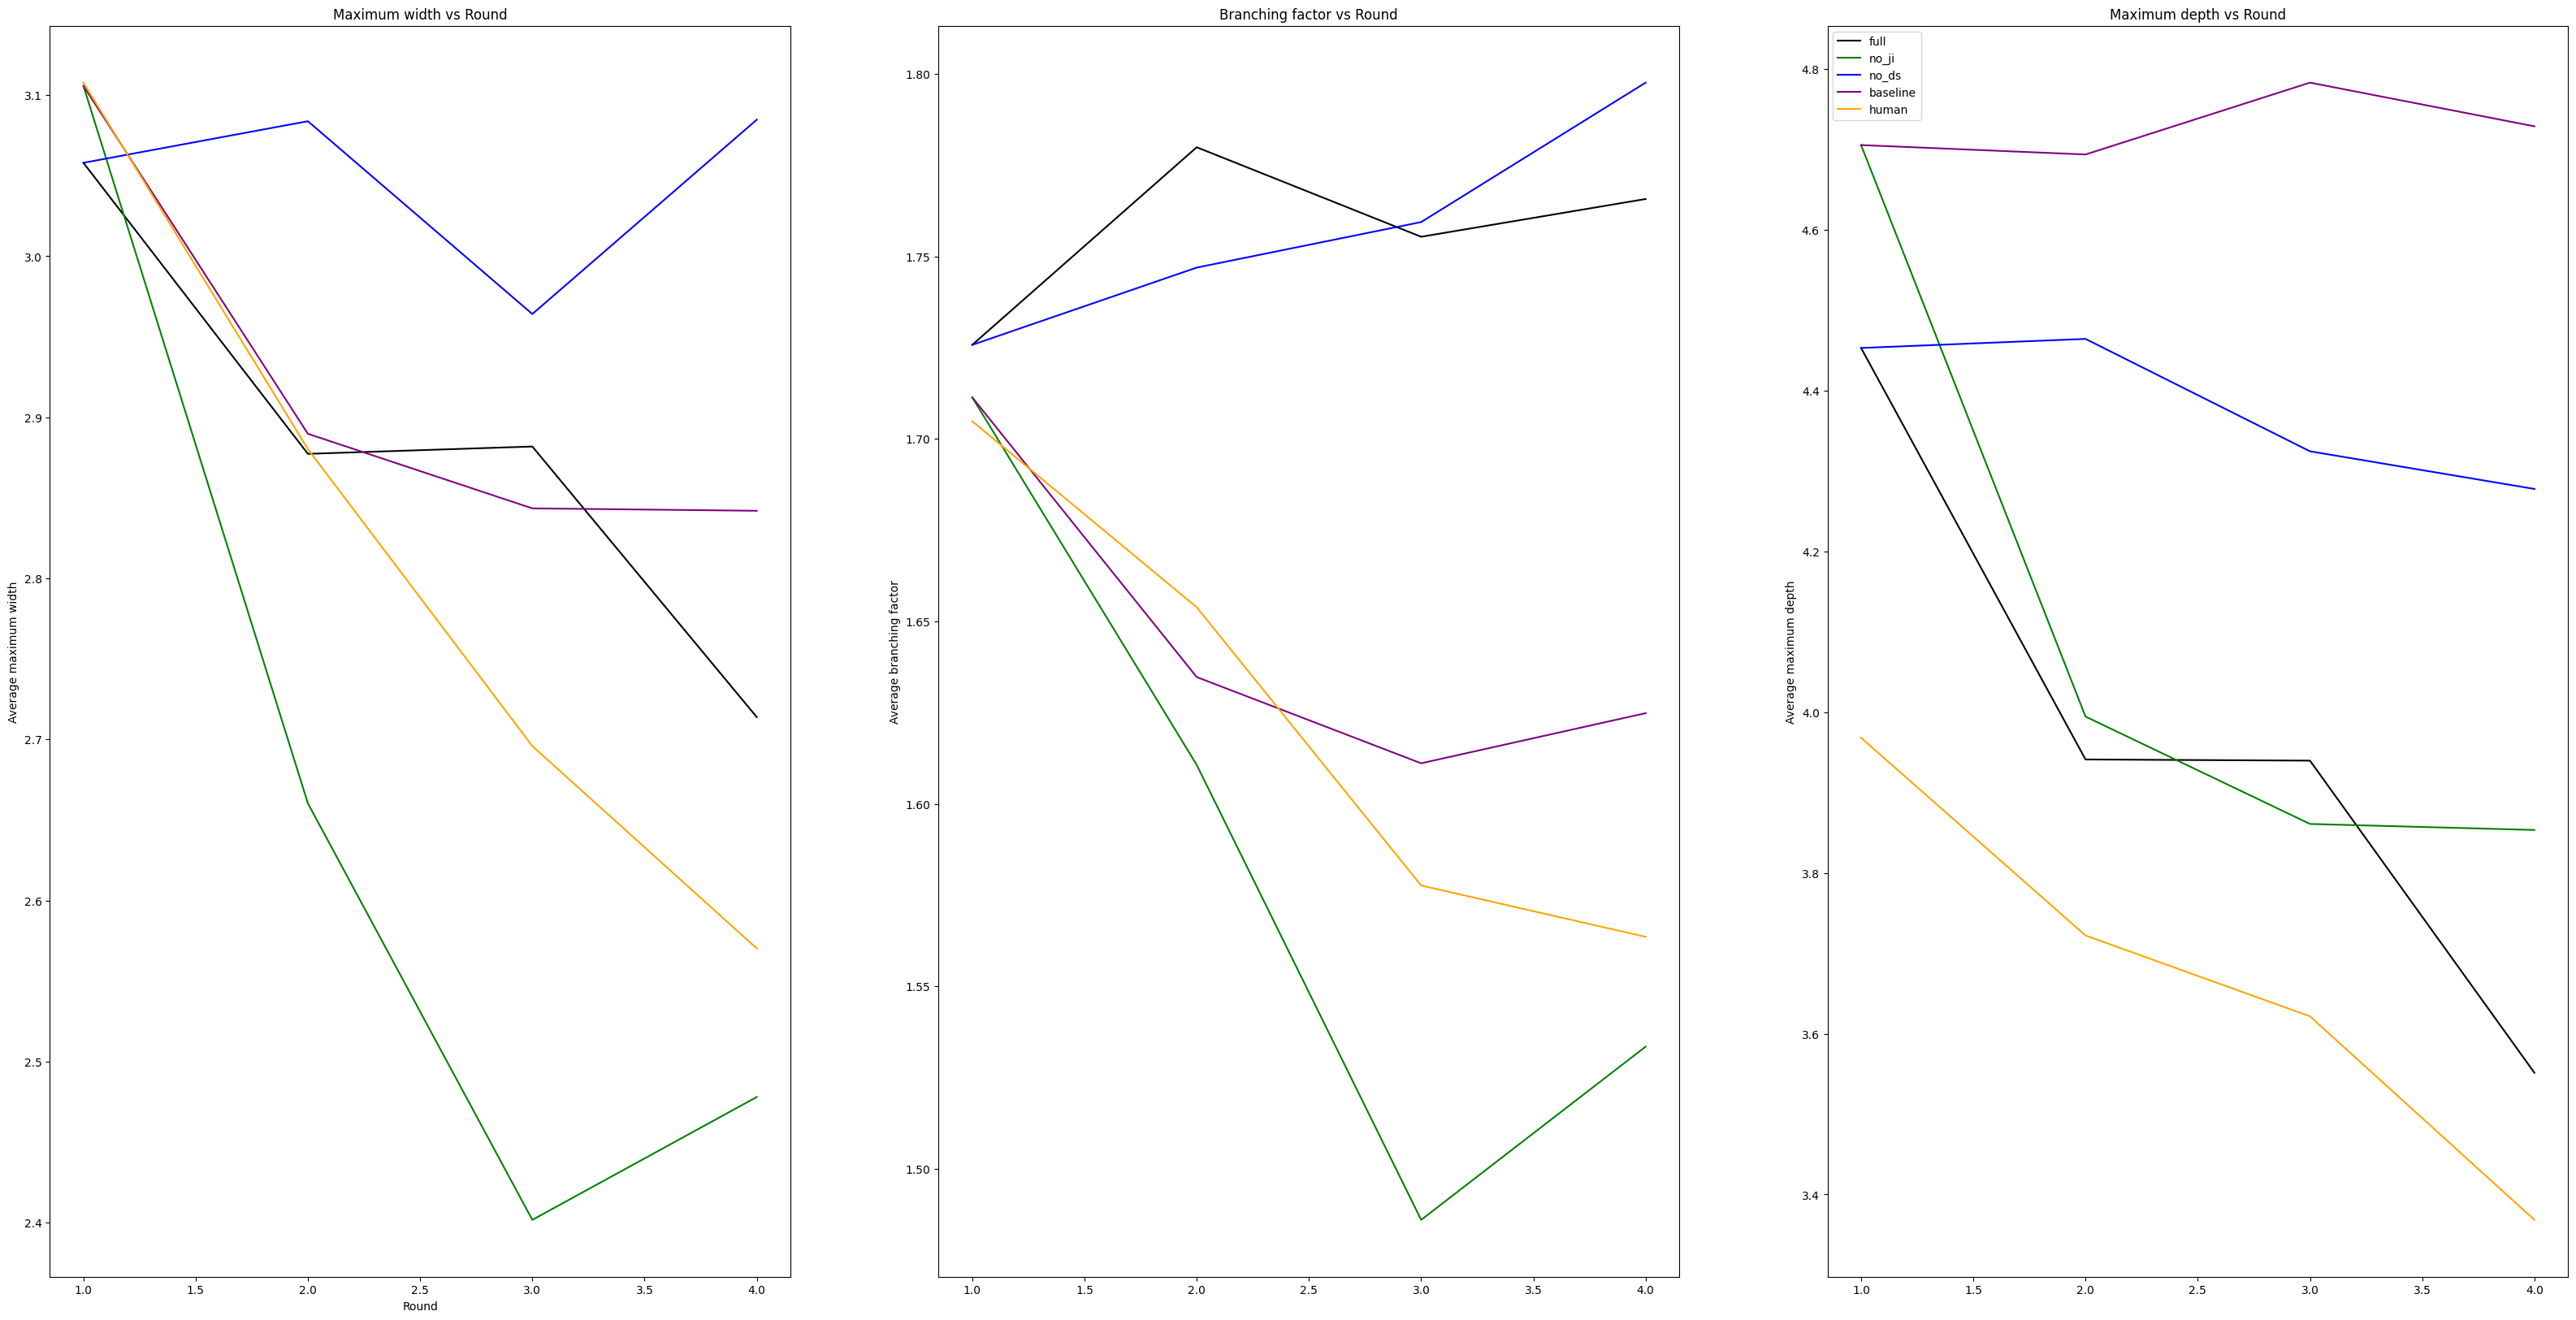

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(40, 20))

treatment_to_color = {
    'full' : 'black', 'no_ji' : 'green', 'no_ds' : 'blue', 'baseline' : 'purple', 'human' : 'orange'
}

for treatment in TREATMENTS + ['human']:
    x = list(range(1, 5))

    # Get the generated vocabulary sizes
    max_widths = []
    max_depths = []
    branching_factors = []
    for i in x:
        use_subset = True
        if treatment == 'human':
            mw, bf, md = human_human_analysis.dependency_metric('human', i, use_subset=use_subset)
        else:
            curr_treatment = treatment
            if i == 1 and treatment in ['no_ds', 'baseline']:
                curr_treatment = 'full' if treatment == 'no_ds' else 'no_ji'
            mw, bf, md = generation_analysis.dependency_metric(curr_treatment, i, use_subset=use_subset)
        max_widths.append(mw)
        max_depths.append(md)
        branching_factors.append(bf)

    axes[0].plot(x, max_widths, label=treatment, color=treatment_to_color[treatment])
    axes[1].plot(x, branching_factors, label=treatment, color=treatment_to_color[treatment])
    axes[2].plot(x, max_depths, label=treatment, color=treatment_to_color[treatment])

    print(treatment, branching_factors)

for i in range(3):
    axes[0].set_xlabel('Round')

axes[0].set_title('Maximum width vs Round')
axes[0].set_ylabel('Average maximum width')
axes[1].set_title('Branching factor vs Round')
axes[1].set_ylabel('Average branching factor')
axes[2].set_title('Maximum depth vs Round')
axes[2].set_ylabel('Average maximum depth')

plt.legend()
plt.show()


## SND

In [9]:
generation_path = os.path.join('/home/mog29', 'cogen/data_and_checkpoints/continual_learning/analysis/human_human.json')
with open(generation_path, 'r') as f:
    generation_data = json.load(f)

In [10]:
def get_tangram_to_utterances(treatment, deployment_round):
    curr_treatment = treatment
    if treatment in ['no_ds', 'baseline'] and deployment_round == 1:
        curr_treatment = 'full' if treatment == 'no_ds' else 'no_ji'
    spacy_docs = generation_analysis.treatment_to_utterances[curr_treatment][deployment_round][0]

    tangram_to_utterances = {}
    for game_id, game_dict in generation_data.items():
        for round_idx, round_dict in game_dict.items():
            target = round_dict['gt_target']
            if target not in tangram_to_utterances:
                tangram_to_utterances[target] = []

            proc_doc = spacy_docs[game_id][round_idx]
            tangram_to_utterances[target].append(proc_doc)

    return tangram_to_utterances

def snd(utterance_list):
    if len(utterance_list) == 1:
        return 0

    utterance_W = []
    for i, utterance in enumerate(utterance_list):
        token_W = []
        for j, token in enumerate(utterance):
            denominator = len(utterance_list) - 1
            num_unseen = 0
            for k, alt_utterance in enumerate(utterance_list):
                if i == k:
                    continue
                k_tokens = set([alt_token.text for alt_token in alt_utterance])
                if token.text not in k_tokens:
                    num_unseen += 1
            token_W.append(num_unseen / denominator)
        utterance_W.append(np.mean(token_W))
    return np.mean(utterance_W)

def get_all_tangram_to_snd(treatment, deployment_round):
    t2u = get_tangram_to_utterances(treatment, deployment_round)
    t2snd = {tangram : snd(utterance_list) for tangram, utterance_list in t2u.items()}

    utterance_counts = [len(utterance_list) for _, utterance_list in t2u.items()]
    
    snd_values = [snd_value for _, snd_value in t2snd.items()]
    return np.mean(snd_values)

In [11]:
treatment_to_values = {}

for treatment in TREATMENTS:
    treatment_to_values[treatment] = []
    for i in range(1, 5):
        treatment_to_values[treatment].append(get_all_tangram_to_snd(treatment, i))

full [0.53959450094282, 0.4608924607019649, 0.4342210591966484, 0.391136851749862]
no_ji [0.47847598857695417, 0.32480211028556977, 0.2229891763420593, 0.22611438380744775]
no_ds [0.53959450094282, 0.4560556561098133, 0.4034755884377133, 0.3690022450072706]
baseline [0.47847598857695417, 0.25485258332369776, 0.19176906360778298, 0.15052200692266315]


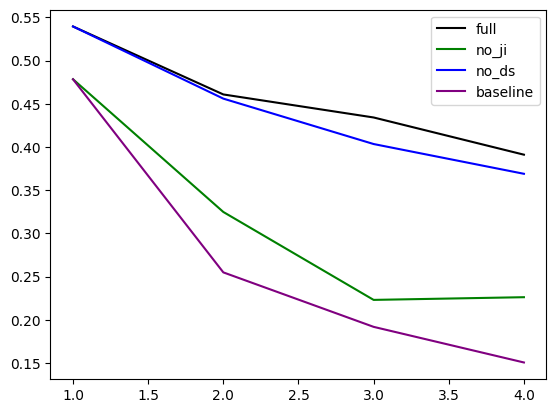

In [12]:
for treatment in TREATMENTS:
    x = list(range(1, 5))
    color = treatment_to_color[treatment]
    snds = treatment_to_values[treatment]
    plt.plot(x, snds, label=treatment, color=treatment_to_color[treatment])
    print(treatment, snds)

plt.legend()
plt.show()

## MAUVE

In [13]:
from mauve import compute_mauve

In [14]:
SPLIT_FOLDER = '/home/mog29/cogen/data_and_checkpoints/continual_learning/analysis'
CACHE_PATH = '/home/mog29/cogen/paper_analysis/analysis_cache/game_subsets'

def get_utterances(treatment, deployment_round):
    # First get the game subset
    with open(os.path.join(CACHE_PATH, f'round_{deployment_round}_subsets_alt.pkl'), 'rb') as f:
        game_subset = pickle.load(f)

    if treatment == "human":
        gen_path = os.path.join(SPLIT_FOLDER, f'human_human.json')
    else:
        gen_path = os.path.join(SPLIT_FOLDER, f'r{deployment_round}_{treatment}.json')
    with open(gen_path, 'r') as f:
        data = json.load(f)

    utterance_list = []
    for game_id, game_dict in data.items():
        for round_idx, round_dict in game_dict.items():
            if (game_id, round_idx) not in game_subset:
                continue
            utterance_list.append(round_dict['chat'].lower())

    return utterance_list

def get_mauve(treatment, deployment_round):
    model_utterances = get_utterances(treatment, deployment_round)
    human_utterances = get_utterances('human', deployment_round)
    return compute_mauve(p_text=human_utterances, q_text=model_utterances, num_buckets=200, device_id=0, batch_size=64).mauve

Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


Featurizing p:   0%|          | 0/31 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/31 [00:00<?, ?it/s]

WARNING clustering 3898 points to 200 centroids: please provide at least 7800 training points


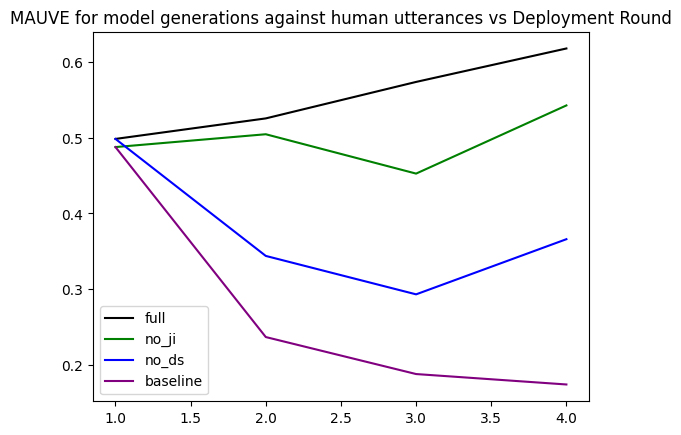

In [15]:
treatment_to_mauve = {}

for treatment in TREATMENTS:
    x = list(range(1, 5))
    mauves = []
    for i in x:
        curr_treatment = treatment
        if treatment in ['no_ds', 'baseline'] and i == 1:
            curr_treatment = 'full' if treatment == 'no_ds' else 'no_ji'
        mauve = get_mauve(curr_treatment, i)
        mauves.append(mauve)

    plt.plot(x, mauves, label=treatment, color=treatment_to_color[treatment])
    treatment_to_mauve[treatment] = mauves

plt.title("MAUVE for model generations against human utterances vs Deployment Round")
plt.legend()
plt.show()

In [16]:
for treatment, mauves in treatment_to_mauve.items():
    print(treatment, mauves)

full [0.4984965591144428, 0.5256155597780208, 0.5738152431098255, 0.6180093558235826]
no_ji [0.487734677750259, 0.5046817613302711, 0.45268010045822615, 0.5427580458972436]
no_ds [0.4984965591144428, 0.3439020443482859, 0.29312699777177686, 0.36600146006666817]
baseline [0.487734677750259, 0.2367062383020382, 0.18781421617943017, 0.17403354506049257]
